In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pydmd import DMD, BOPDMD
from pydmd.plotter import plot_eigs, plot_summary
from pydmd.preprocessing import hankel_preprocessing

from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import odeint
from numpy.fft import fft,ifft,fftfreq



In [2]:
# simulate NLS
m = 250
n = 256
l = 20.0

t = np.linspace(0,6,2*m)
x = np.linspace(-l/2,l/2,n+1)[0:n]
dt = t[1]-t[0]
dx = x[2]-x[1]

def nls_rhs(ut_sep, t, params):
    
    n, k = params
    ut = ut_sep[0:n] + 1j*ut_sep[n:]
    u = ifft(ut)
    deriv = -1j/2.0*(k**2)*ut + 1j*fft((abs(u)**2)*u)
    return np.hstack([np.real(deriv),np.imag(deriv)])

k = 2*np.pi*np.fft.fftfreq(n, d = float(l)/n)
params = (n, k)

rtol = 1e-10  # Relative tolerance
atol = 1e-10  # Absolute tolerance

u0 = 2*np.cosh(x)**-1
ut0= np.hstack([np.real(fft(u0)),np.imag(fft(u0))])
ut = odeint(nls_rhs, ut0, t, args=(params,), rtol=rtol, atol=atol)
ut = (ut[:,0:n] + 1j*ut[:,n:]).T
    
u = np.zeros((n,2*m), dtype = complex)
for j in range(2*m):
    u[:,j]=ifft(ut[:,j]);

mean = 0
std_dev = 0.2
random_matrix = np.random.normal(mean, std_dev, size=(n, 2*m))
    
u = (u + random_matrix).T



(500, 256)


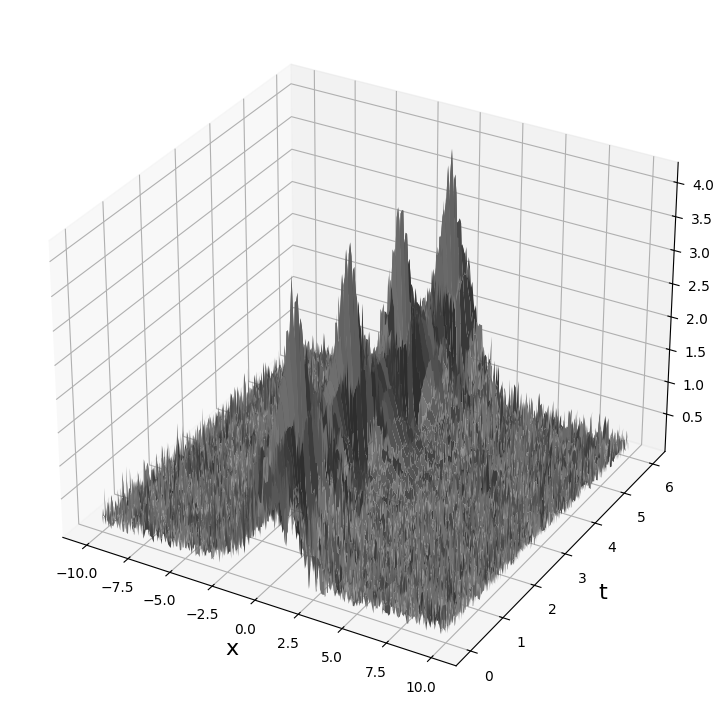

In [3]:
X, T = np.meshgrid(x, t)

fig = plt.figure(figsize=(20, 20))
ax1 = fig.add_subplot(2, 2, 1, projection='3d')
ax1.plot_surface(X, T, np.abs(u), color='gray')

plt.xlabel('x', fontsize = 16)
plt.ylabel('t', fontsize = 16)

print(u.shape)

/Users/nathankutz/Documents/GitHub/PyDMDsparse/pydmd/bopdmd.py:937: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


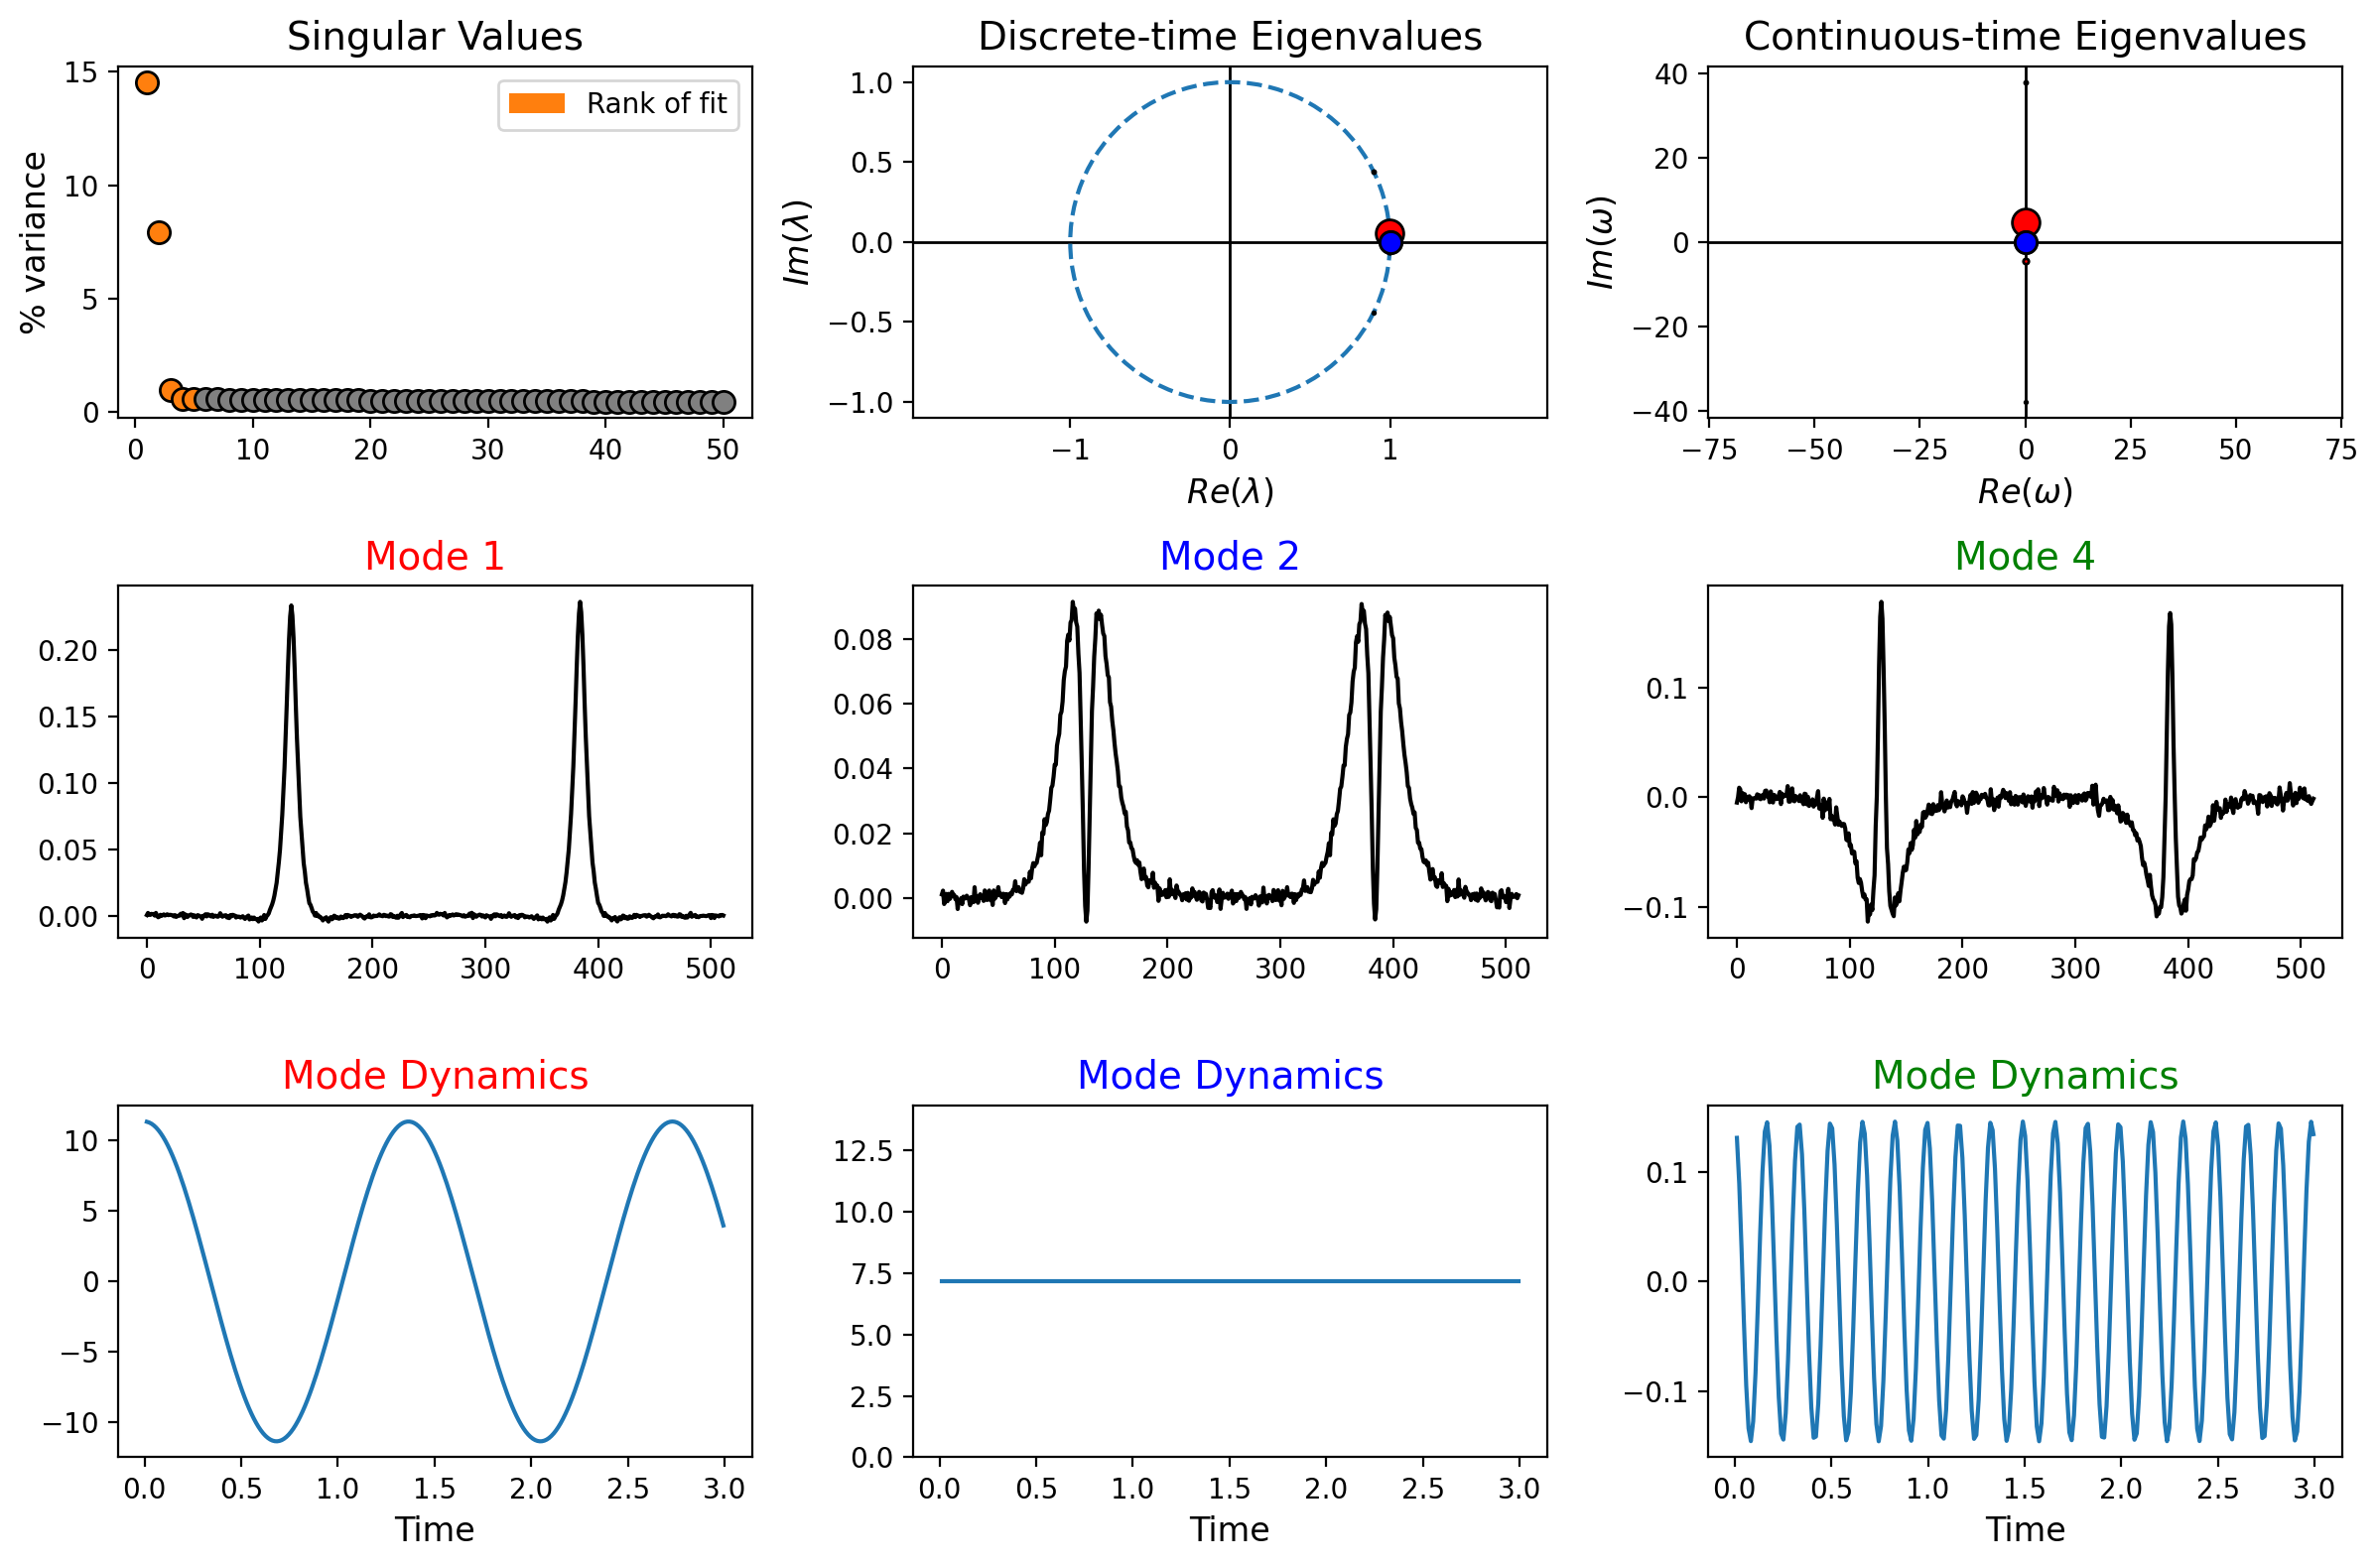

In [4]:

U = u[:m,:].T
#U = u.T - np.mean(u.T)

#delay_optdmd = hankel_preprocessing(BOPDMD(svd_rank=21, num_trials=0), d=2)
delay_optdmd = hankel_preprocessing(BOPDMD(svd_rank=5, num_trials=0, eig_constraints={"imag", "conjugate_pairs"}), d=2)
delay_optdmd.fit(U, t=t[1:m])
plot_summary(delay_optdmd, index_modes=[0,1,3], order='F') # pick correct modes


In [5]:
# Produce forecast
time_recon = t[:m]
time_forecast = t[m:]
recon_mean = delay_optdmd.forecast(time_recon)
forecast_mean = delay_optdmd.forecast(time_forecast)

Recon = recon_mean[:n,:].T 
Fore = forecast_mean[:n,:].T

#E_forecast =  np.abs(Fore) - np.abs(u[m:,:]) 
#E_reconstruct = np.abs(Recon) - np.abs(u[:m,:]) 
E_forecast =  np.abs(Fore - u[m:,:]) 
E_reconstruct = np.abs(Recon - u[:m,:]) 


Ef = np.linalg.norm(E_forecast, 'fro')/ np.linalg.norm(np.abs(u[m:,:]), 'fro')
Er = np.linalg.norm(E_reconstruct, 'fro')/np.linalg.norm(np.abs(u[:m,:]), 'fro')

print(Ef)
print(Er)



0.8042392653672352
0.423973148873688


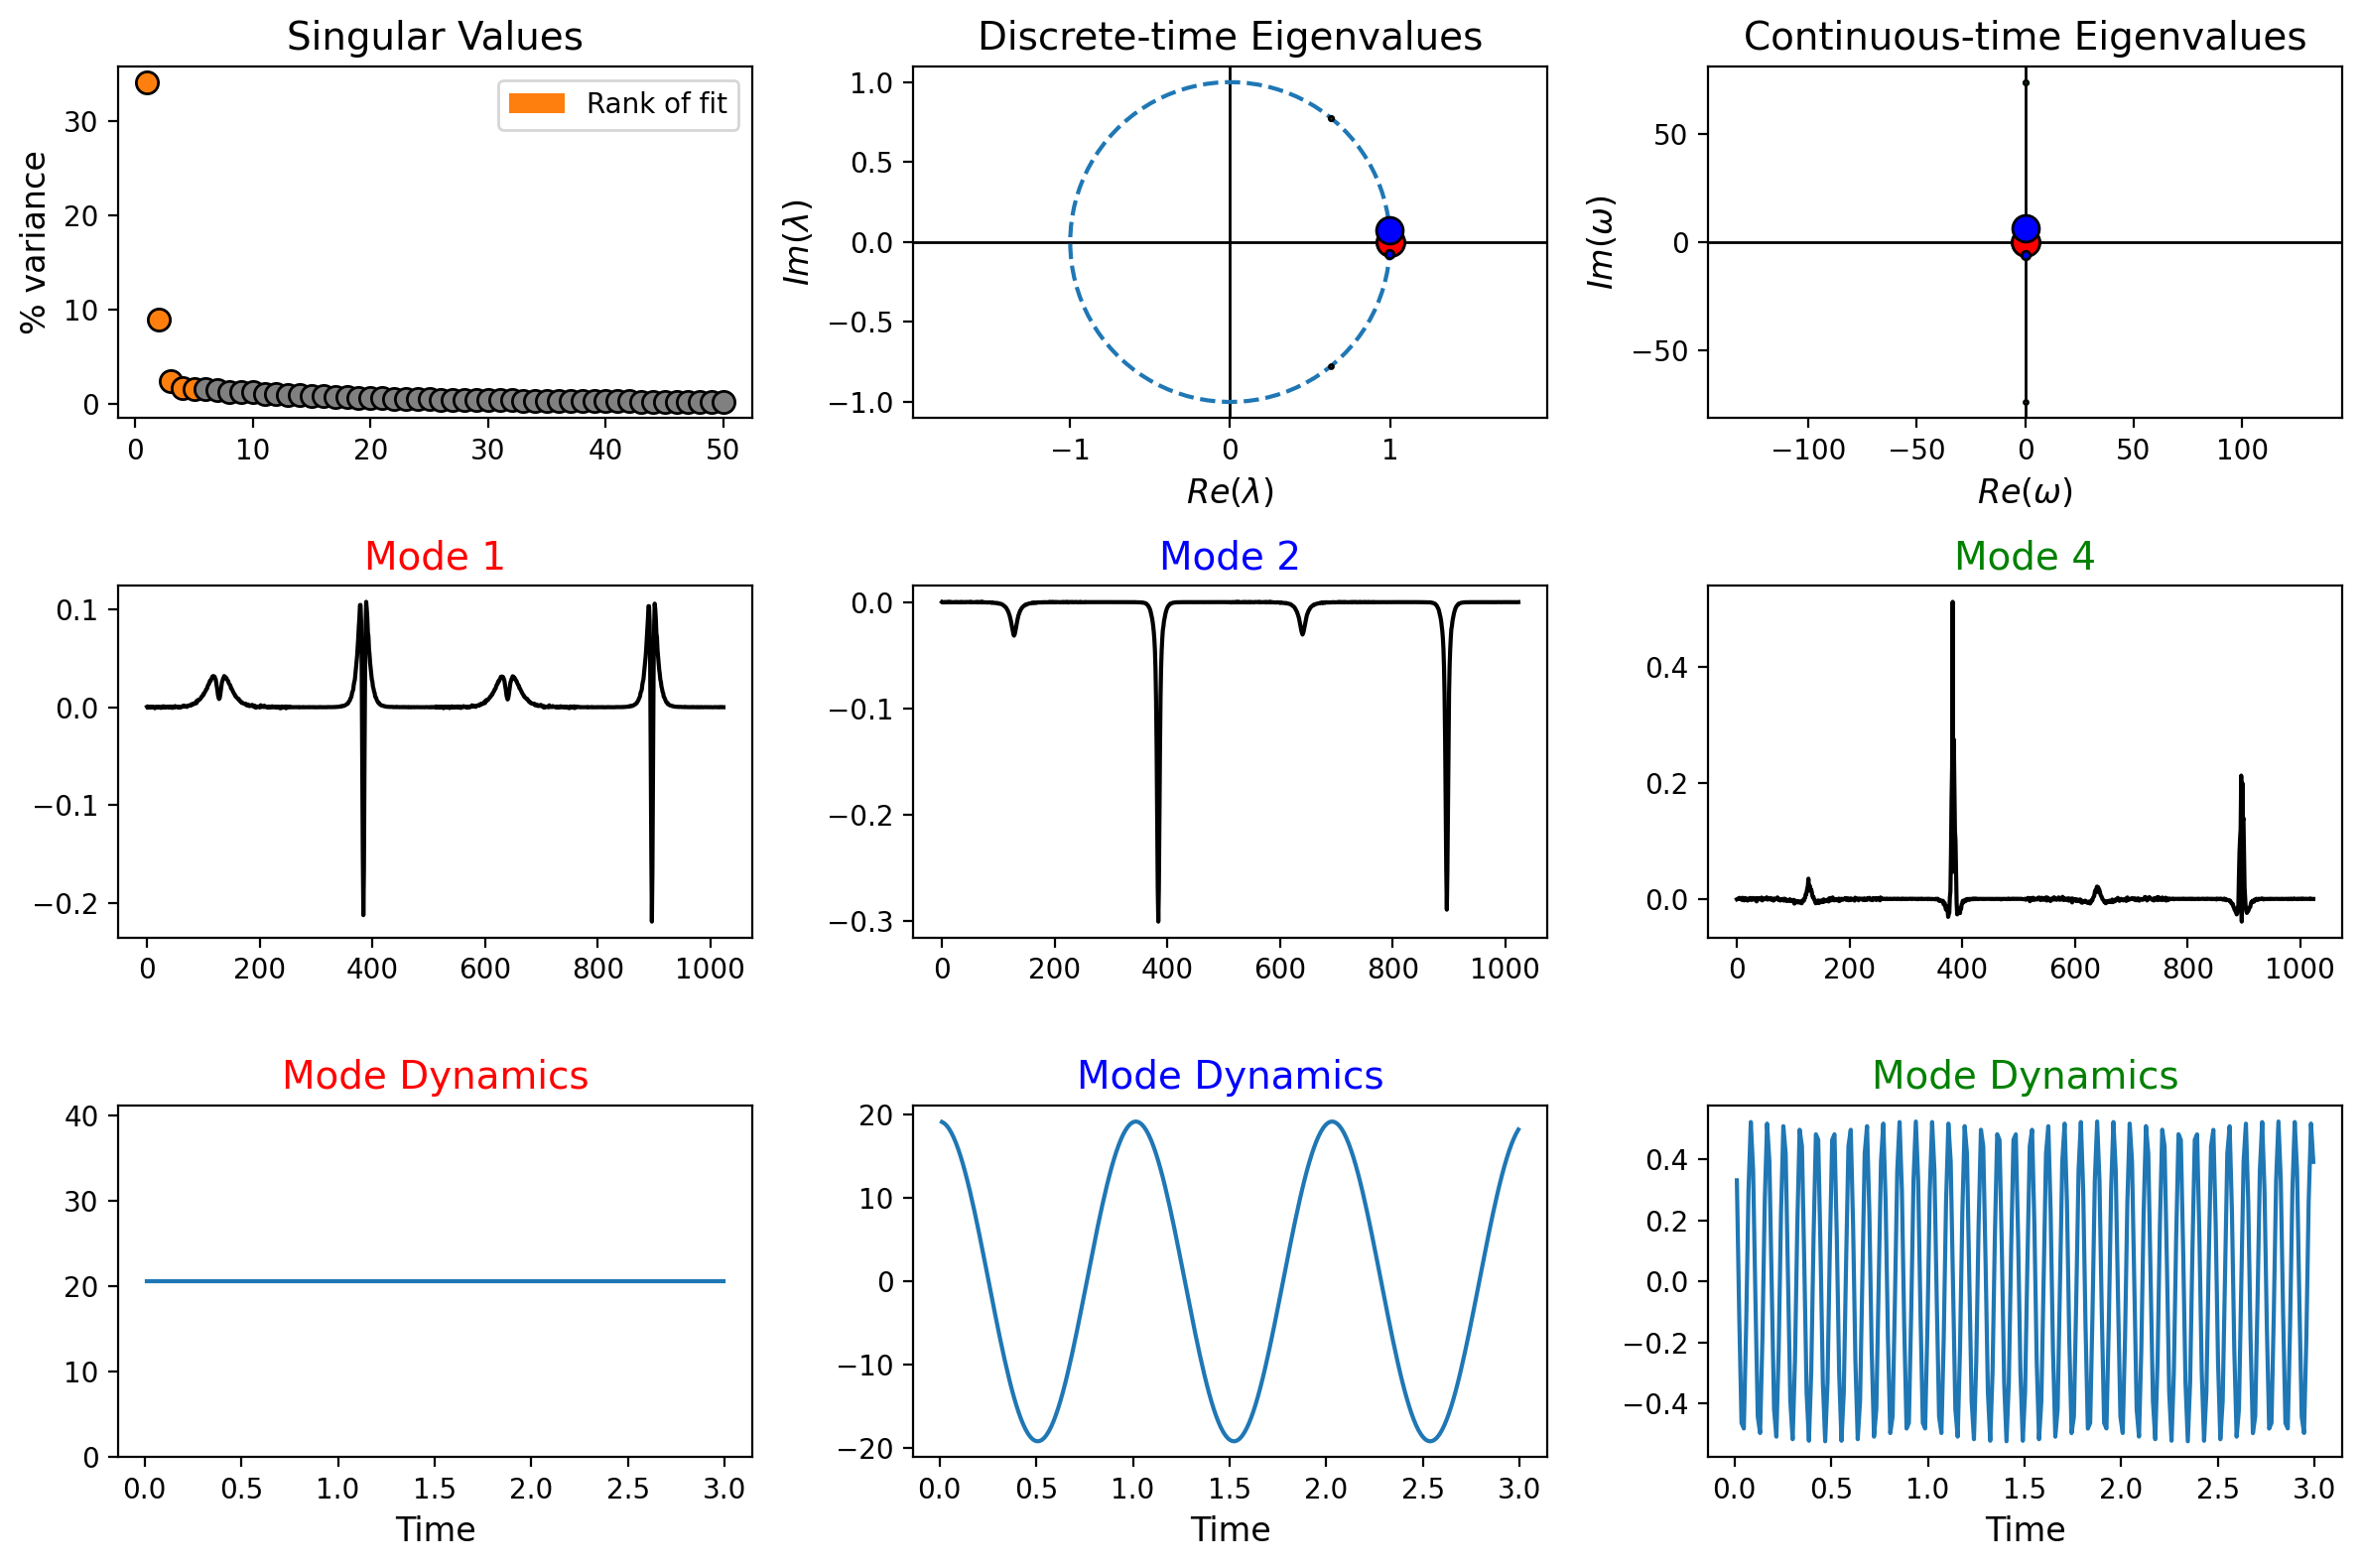

In [6]:
# enrich observables
u1 = u[:m,:].T
u3 = ( ( np.abs(u1)**2 )*u1 )
U  = np.vstack((u1, u3))

#delay_optdmd = hankel_preprocessing(BOPDMD(svd_rank=21, num_trials=0), d=2)
delay_optdmd = hankel_preprocessing(BOPDMD(svd_rank=5, num_trials=0, eig_constraints={"imag", "conjugate_pairs"}), d=2)
# Cut off a value of t to match the number of snapshots in the hankel matrix:
delay_optdmd.fit(U, t=t[1:m])
plot_summary(delay_optdmd, index_modes=[0,1,3], order='F') # pick correct modes



In [7]:
# Produce forecast
recon_mean = delay_optdmd.forecast(time_recon)
forecast_mean = delay_optdmd.forecast(time_forecast)


Recon = recon_mean[:n,:].T 
Fore = forecast_mean[:n,:].T

E_forecast =  np.abs(Fore - u[m:,:]) 
E_reconstruct = np.abs(Recon- u[:m,:]) 
#E_forecast =  np.abs(Fore) - np.abs(u[m:,:]) 
#E_reconstruct = np.abs(Recon) - np.abs(u[:m,:]) 


Ef = np.linalg.norm(E_forecast, 'fro')/ np.linalg.norm(np.abs(u[m:,:]), 'fro')
Er = np.linalg.norm(E_reconstruct, 'fro')/np.linalg.norm(np.abs(u[:m,:]), 'fro')

print(Ef)
print(Er)


1.0985754765893245
0.8389429802288798


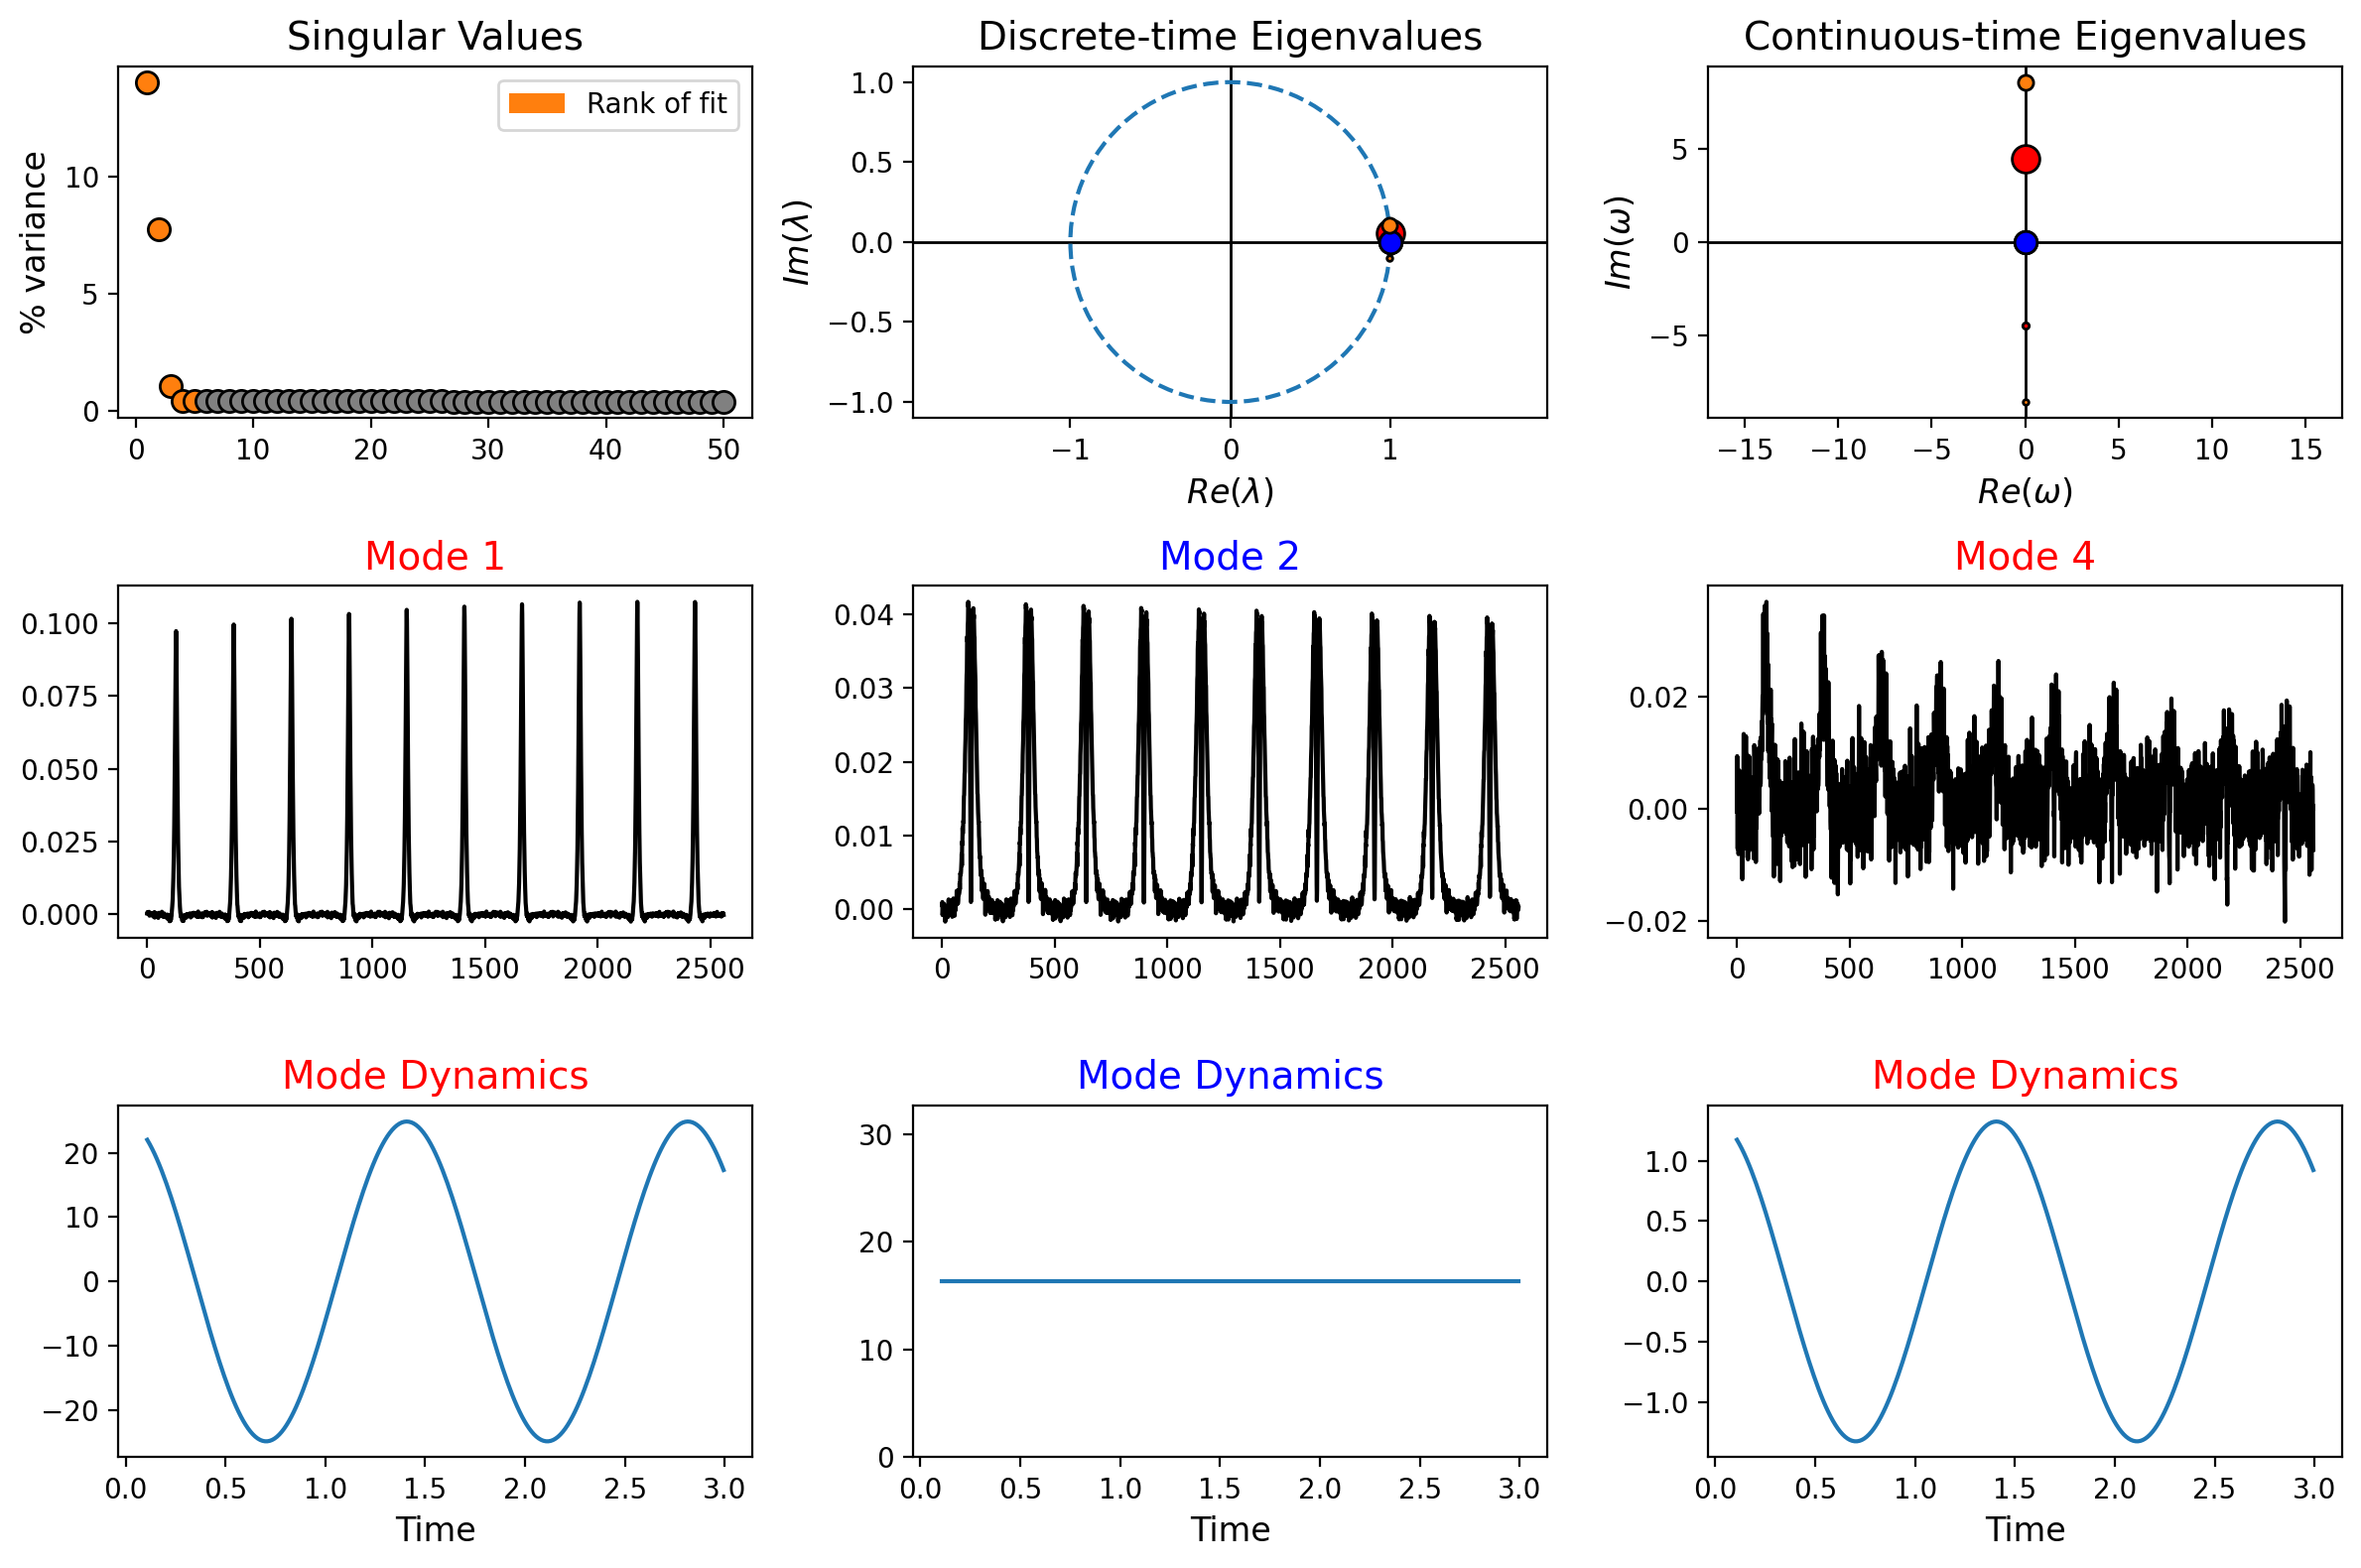

In [8]:
# time delay
U = u[:m,:].T

delay_optdmd = hankel_preprocessing(BOPDMD(svd_rank=5, num_trials=0, eig_constraints={"imag", "conjugate_pairs"}), d=10)
delay_optdmd.fit(U, t=t[9:m])
plot_summary(delay_optdmd, index_modes=[0,1,3], order='F') # pick correct modes




In [9]:
# Produce forecast
time_recon = t[:m]
time_forecast = t[m:]
recon_mean = delay_optdmd.forecast(time_recon)
forecast_mean = delay_optdmd.forecast(time_forecast)

Recon = recon_mean[:n,:].T 
Fore = forecast_mean[:n,:].T

#E_forecast =  np.abs(Fore) - np.abs(u[m:,:]) 
#E_reconstruct = np.abs(Recon) - np.abs(u[:m,:]) 
E_forecast =  np.abs(Fore - u[m:,:]) 
E_reconstruct = np.abs(Recon - u[:m,:]) 


Ef = np.linalg.norm(E_forecast, 'fro')/ np.linalg.norm(np.abs(u[m:,:]), 'fro')
Er = np.linalg.norm(E_reconstruct, 'fro')/np.linalg.norm(np.abs(u[:m,:]), 'fro')

print(Ef)
print(Er)

0.9089709224955181
0.5548125474853859
